# Train SVR Model on Fuchs Data

In [1]:
device = "GPU" # CPU or GPU (must set manually, don't know how to do this automatically in rapids 22.10)
if device == "GPU":
    print("CUDA is available: using GPU")
    import cudf as pd
    import cupy as np
    import cuml
    from cuml.svm import SVR
    from cuml.model_selection import train_test_split
    from cuml.preprocessing import StandardScaler
    from cuml.metrics import mean_squared_error as mse
    def mape(y_true, y_pred):
        return np.mean(np.abs(y_true-y_pred)/y_true)
    import pynvml
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(0)
else:
    print("CUDA not available: using CPU")
    import numpy as np
    import pandas as pd
    from sklearn.svm import SVR
    from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm, trange
import itertools
import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from datetime import datetime
import os
import csv
from sklearn.multioutput import RegressorChain
import gc
from tqdm import trange, tqdm

CUDA is available: using GPU


## Set Noise Level, Dataset, Output Directory

In [2]:
noise = 30 # ADJUST level of gaussian noise added to outputs
mod_type = 'svr'
description = mod_type + '_noise-' + str(noise)
result_dir = 'results/' + description + '/' # RESULTS stored in this folder
# Check to see if directory exists, make it if it does not
if(not os.path.exists(result_dir)):
    os.makedirs(result_dir)
filename = '../datasets/fuchs_v3-2_seed-5_points_25000_noise_' + str(noise) + '.csv'  # CHANGE TO DESIRED DATA FILE
df = pd.read_csv(filename)

## Get Input

In [3]:
input_list = ['Intensity_(W_cm2)', 'Target_Thickness (um)', 'Focal_Distance_(um)'] # independent variables
output_list = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)',
               'Max_Proton_Energy_Exact_(MeV)', 'Total_Proton_Energy_Exact_(MeV)', 'Avg_Proton_Energy_Exact_(MeV)'] # training outputs
X = df[input_list].copy()
y = df[output_list].copy()
X[X.columns[0]] = np.log(X[X.columns[0]]) # Apply log scaling to intensity
for col in y.columns:
    y[col] = np.log(y[col]) # Apply log scaling to energy

#Choose a datatype for X and y to be in
dataType = 'float64'

if device == "GPU":
    X = X.to_cupy().astype(dtype=dataType)
    y = y.to_cupy().astype(dtype=dataType)
else:
    X = X.to_numpy().astype(dtype=dataType)
    y = y.to_numpy().astype(dtype=dataType)
    
train_split = 0.8 # Reserve 80% of entire dataset for training
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, train_size=train_split, shuffle = False)
y_train_full = y_train_full[:, 0:3]
y_test_full = y_test_full[:, 0:6] # Includes noisy data and exact fuchs data

## Specify Hyper-Parameters and Initialize Variables

In [4]:
C = 2.5
epsilon = 1e-2
tol = 1e-3

num_inputs = X_train_full.shape[1]
num_outputs = y_train_full.shape[1]
    
num_splits = 40
data_fractions =  np.linspace(1/num_splits, 1, num_splits) # 1k, 2k, ..., 20k training points
points_train = np.round(data_fractions*len(X_train_full)).astype(int)
points_test = np.round(data_fractions*len(X_test_full)).astype(int)
print('training points: ', points_train)

time_list = np.zeros(num_splits)
train_mse = np.zeros((num_splits, num_outputs))
train_mape = np.zeros((num_splits, num_outputs))
test_mse_noisy = np.zeros((num_splits, num_outputs))
test_mape_noisy = np.zeros((num_splits, num_outputs))
test_mse_exact = np.zeros((num_splits, num_outputs))
test_mape_exact = np.zeros((num_splits, num_outputs))
test_mape_exact_uncorrected = np.zeros((num_splits, num_outputs))
mem_used = np.zeros((num_splits, num_outputs))

training points:  [  500  1000  1500  2000  2500  3000  3500  4000  4500  5000  5500  6000
  6500  7000  7500  8000  8500  9000  9500 10000 10500 11000 11500 12000
 12500 13000 13500 14000 14500 15000 15500 16000 16500 17000 17500 18000
 18500 19000 19500 20000]


## Training Loop

In [5]:
print('theoretical correction factor: ', round(np.sqrt(1 + (noise/100)**2).tolist(), 3))
outs = ['max', 'tot', 'avg']
pbar = trange(num_splits, desc='training split', leave=True)
for i in pbar:

    X_train = X_train_full[0:points_train[i], 0:num_inputs].copy()
    y_train = y_train_full[0:points_train[i]].copy()

    X_test = X_test_full[0:points_test[i], 0:num_inputs].copy()
    y_test_noisy = y_test_full[0:points_test[i]].copy()
    y_test_exact = y_test_full[0:points_test[i], num_inputs:num_inputs+num_outputs].copy()
    
    # StandardScaler: z-score normalization
    ss_in = StandardScaler()
    ss_in.fit(X_train)
    X_train_norm = ss_in.transform(X_train)
    X_test_norm = ss_in.transform(X_test)
    
    ss_out = StandardScaler()
    ss_out.fit(y_train)
    y_train_norm = ss_out.transform(y_train)

    start_time = time.time()
    
    svrs = []
    for j in range(num_outputs):
        # Train SVR
        svrs.append(SVR(C=C, epsilon=epsilon, tol=tol))
        svrs[j].fit(X_train_norm, y_train_norm[:, j])
        
        # Make Predictions
        y_train_predict = svrs[j].predict(X_train_norm)
        y_test_predict = svrs[j].predict(X_test_norm)
        y_train_predict_unscaled = np.exp(ss_out.inverse_transform(y_train_predict.reshape(-1, 1).repeat(3, 1)))[:, j]
        y_test_predict_unscaled = np.exp(ss_out.inverse_transform(y_test_predict.reshape(-1, 1).repeat(3, 1)))[:, j]

        # Correct for Log Scaling
        correction_factor = np.mean(np.exp(y_train[:, j])/y_train_predict_unscaled)
        y_train_predict_corrected = y_train_predict_unscaled*correction_factor
        y_test_predict_corrected = y_test_predict_unscaled*correction_factor
        
        # Record Metrics
        train_mse[i, j] = mse(np.exp(y_train[:, j]), y_train_predict_corrected)
        train_mape[i, j] = mape(np.exp(y_train[:, j]), y_train_predict_corrected)
        test_mse_noisy[i, j] = mse(np.exp(y_test_noisy[:, j]), y_test_predict_corrected)
        test_mape_noisy[i, j] = mape(np.exp(y_test_noisy[:, j]), y_test_predict_corrected)
        test_mse_exact[i, j] = mse(np.exp(y_test_exact[:, j]), y_test_predict_corrected)
        test_mape_exact[i, j] = mape(np.exp(y_test_exact[:, j]), y_test_predict_corrected)
        test_mape_exact_uncorrected[i, j] = mape(np.exp(y_test_exact[:, j]), y_test_predict_unscaled)
            
        # Append output to input for next iteration in chained output regression
        X_train_norm = np.concatenate([X_train_norm, y_train_predict.reshape(-1, 1)], axis=1)
        X_test_norm = np.concatenate([X_test_norm, y_test_predict.reshape(-1, 1)], axis=1)

        # Record memory usage 
        if device == "GPU":         
            mem = pynvml.nvmlDeviceGetMemoryInfo(handle)
            mem_used[i, j] = mem.used/2**30
            
        pbar.set_postfix({'test mape':str(round(test_mape_exact[i, j].tolist()*100, 2)), 'corr fac': str(round(correction_factor.tolist(), 3)), 'E': outs[j], 'mem': round(mem_used[i,j].tolist(), 2)})
            
        gc.collect()
    
    end_time = time.time()
    time_list[i] = end_time - start_time

theoretical correction factor:  1.044


training split: 100%|██████████| 40/40 [00:45<00:00,  1.13s/it, test mape=2.12, corr fac=1.043, E=avg, mem=1.6] 


## GPU memory consumption

Text(0, 0.5, 'Average GPU Memory (GiB)')

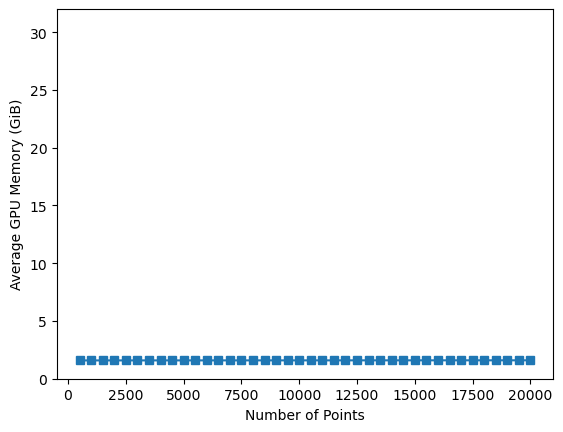

In [6]:
fig, ax = plt.subplots()
ax.plot(points_train.get(), np.mean(mem_used, axis=1).get(), marker='s')
ax.set_ylim([0, 32])
ax.set_xlabel("Number of Points")
ax.set_ylabel("Average GPU Memory (GiB)")
#fig.savefig(result_dir+'gpu_mem.png')

## Time to Train

total run time:  44.49478006362915  s


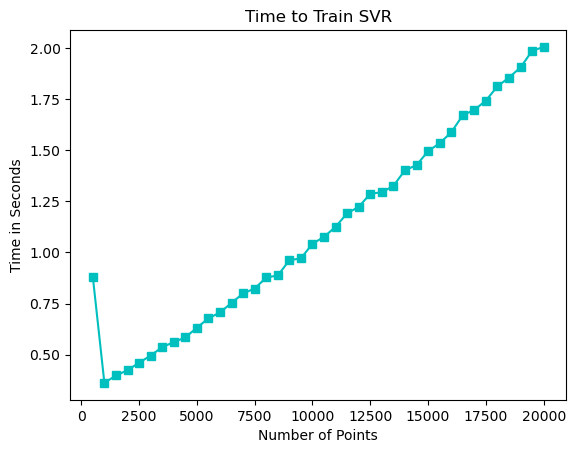

In [7]:
print('total run time: ', sum(time_list), ' s')
fig, ax = plt.subplots()
ax.set_title("Time to Train {}".format(mod_type.upper()))
ax.set_xlabel("Number of Points")
ax.set_ylabel("Time in Seconds")
ax.plot(points_train.get(), time_list.get(), marker='s', c='c', label='Time')
#fig.savefig(result_dir+'time.png')

## Mean Squared Error

Text(0, 0.5, 'Mean Squared Error')

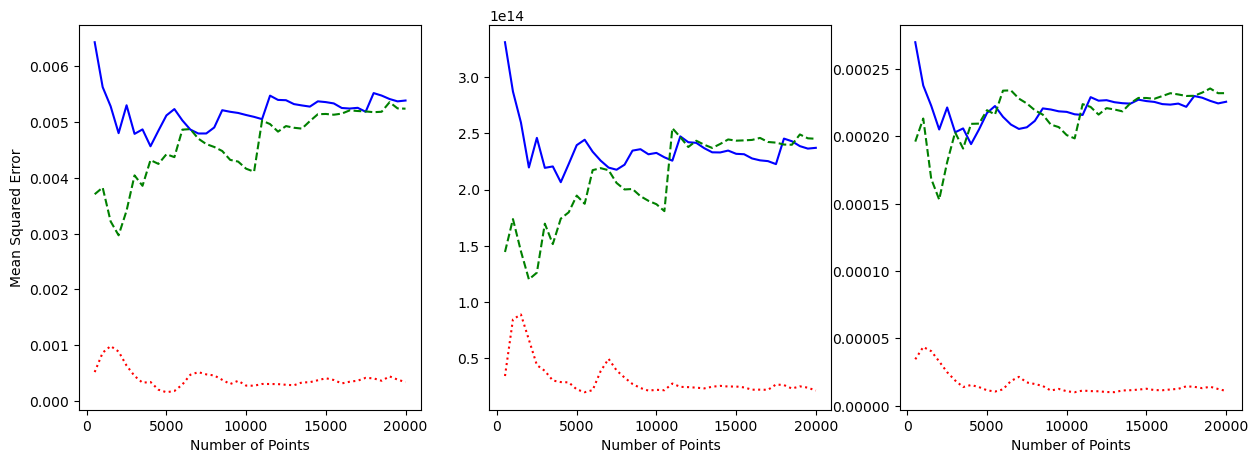

In [8]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for j in range(num_outputs):
    ax[j].plot(points_train.get(), train_mse[:, j].get(), c='b', label='train')
    ax[j].plot(points_train.get(), test_mse_noisy[:, j].get(), c='g', label='test noisy', linestyle='dashed')
    ax[j].plot(points_train.get(), test_mse_exact[:, j].get(), c='r', label='test exact', linestyle='dotted')
    ax[j].set_xlabel("Number of Points")
ax[0].set_ylabel("Mean Squared Error")

## Mean Absolute Percentage Error

total run time:  44.49478006362915  s


Text(0, 0.5, 'Mean Absolute Percentage Error')

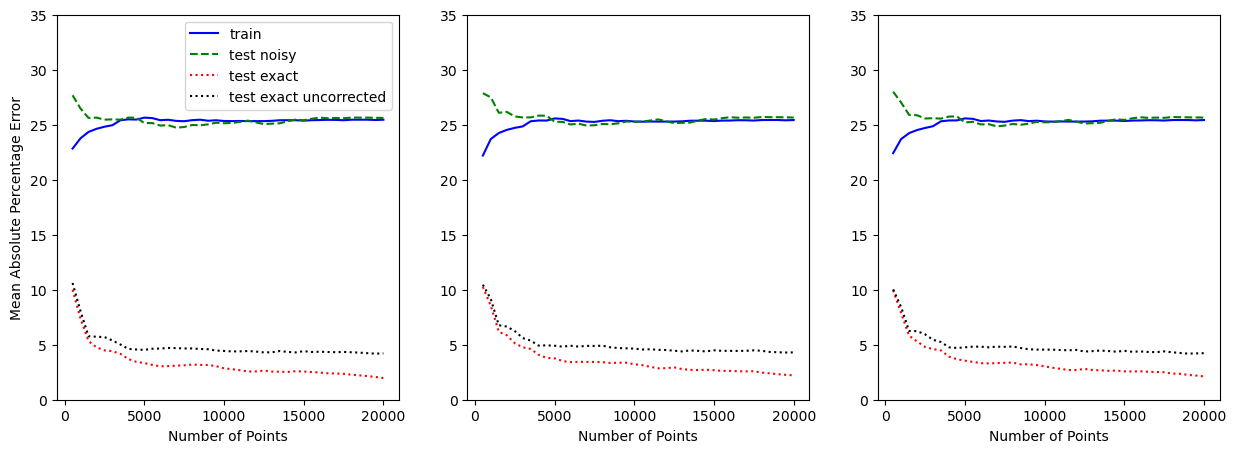

In [9]:
print('total run time: ', sum(time_list), ' s')
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for j in range(num_outputs):
    ax[j].plot(points_train.get(), train_mape[:, j].get()*100, c='b', label='train')
    ax[j].plot(points_train.get(), test_mape_noisy[:, j].get()*100, c='g', label='test noisy', linestyle='dashed')
    ax[j].plot(points_train.get(), test_mape_exact[:, j].get()*100, c='r', label='test exact', linestyle='dotted')
    ax[j].plot(points_train.get(), test_mape_exact_uncorrected[:, j].get()*100, c='k', label='test exact uncorrected', linestyle='dotted')
    ax[j].set_xlabel("Number of Points")
    ax[j].set_ylim(0, noise+5)
ax[0].legend(loc='upper right')
ax[0].set_ylabel("Mean Absolute Percentage Error")

## Store Metrics to CSV file

In [10]:
columns = ['train_points', 'gpu_memory', 'time', 
            'train_mse_max', 'train_mse_tot', 'train_mse_avg',
            'test_mse_noisy_max', 'test_mse_noisy_tot', 'test_mse_noisy_avg',
            'test_mse_exact_max', 'test_mse_exact_tot', 'test_mse_exact_avg',
            'train_mape_max', 'train_mape_tot', 'train_mape_avg',
            'test_mape_noisy_max', 'test_mape_noisy_tot', 'test_mape_noisy_avg',
            'test_mape_exact_max', 'test_mape_exact_tot', 'test_mape_exact_avg',
            'test_mape_exact_uncorrected_max', 'test_mape_exact_uncorrected_tot', 'test_mape_exact_uncorrected_avg']
data = [points_train, np.mean(mem_used, axis=1), time_list,
        train_mse[:, 0], train_mse[:, 1], train_mse[:, 2],
        test_mse_noisy[:, 0], test_mse_noisy[:, 1], test_mse_noisy[:, 2],
        test_mse_exact[:, 0], test_mse_exact[:, 1], test_mse_exact[:, 2],
        train_mape[:, 0], train_mape[:, 1], train_mape[:, 2],
        test_mape_noisy[:, 0], test_mape_noisy[:, 1], test_mape_noisy[:, 2],
        test_mape_exact[:, 0], test_mape_exact[:, 1], test_mape_exact[:, 2],
        test_mape_exact_uncorrected[:, 0], test_mape_exact_uncorrected[:, 1], test_mape_exact_uncorrected[:, 2]]
output_df = pd.DataFrame(dict(zip(columns, data)))
display(output_df)

,train_points,gpu_memory,time,train_mse_max,train_mse_tot,train_mse_avg,test_mse_noisy_max,test_mse_noisy_tot,test_mse_noisy_avg,test_mse_exact_max,...,train_mape_avg,test_mape_noisy_max,test_mape_noisy_tot,test_mape_noisy_avg,test_mape_exact_max,test_mape_exact_tot,test_mape_exact_avg,test_mape_exact_uncorrected_max,test_mape_exact_uncorrected_tot,test_mape_exact_uncorrected_avg
0,500,1.584839,0.880630,0.006432,3.309545e+14,0.000270,0.003706,1.444950e+14,0.000196,0.000517,...,0.224173,0.276796,0.278686,0.280018,0.099995,0.102582,0.099447,0.106144,0.104593,0.100324
1,1000,1.584839,0.361519,0.005628,2.871058e+14,0.000238,0.003827,1.737428e+14,0.000213,0.000864,...,0.236980,0.264688,0.274874,0.270159,0.073672,0.085278,0.078634,0.080462,0.091424,0.084299
2,1500,1.584839,0.397947,0.005284,2.596078e+14,0.000223,0.003219,1.451409e+14,0.000168,0.000983,...,0.242354,0.256153,0.260861,0.258965,0.053298,0.061727,0.058143,0.057777,0.067746,0.062529
3,2000,1.585490,0.423633,0.004802,2.196098e+14,0.000205,0.002970,1.201184e+14,0.000153,0.000885,...,0.245181,0.256468,0.261669,0.258621,0.047679,0.058612,0.053086,0.057230,0.066534,0.062342
4,2500,1.585490,0.460473,0.005302,2.459337e+14,0.000221,0.003412,1.261047e+14,0.000181,0.000633,...,0.247025,0.254623,0.257517,0.255662,0.044845,0.051386,0.047952,0.057002,0.062453,0.059463
5,3000,1.586141,0.495343,0.004789,2.192785e+14,0.000203,0.004044,1.696639e+14,0.000203,0.000447,...,0.248660,0.254844,0.256628,0.255930,0.044138,0.047661,0.046048,0.053824,0.056103,0.054468
6,3500,1.586792,0.536608,0.004869,2.205292e+14,0.000206,0.003857,1.515061e+14,0.000191,0.000326,...,0.253143,0.254601,0.256662,0.255547,0.041696,0.046172,0.044831,0.050189,0.053720,0.052476
7,4000,1.586792,0.561188,0.004566,2.065294e+14,0.000194,0.004318,1.741288e+14,0.000209,0.000339,...,0.253872,0.256495,0.258277,0.257400,0.036978,0.040864,0.039191,0.046217,0.049198,0.047659
8,4500,1.586792,0.584258,0.004847,2.227674e+14,0.000205,0.004250,1.797873e+14,0.000209,0.000200,...,0.253944,0.256362,0.258147,0.257558,0.034451,0.038045,0.036802,0.045662,0.049450,0.047017
9,5000,1.586792,0.631834,0.005119,2.394419e+14,0.000217,0.004423,1.946020e+14,0.000219,0.000155,...,0.255756,0.251501,0.252734,0.252003,0.033312,0.037611,0.035521,0.045296,0.049068,0.047655


In [11]:
output_df.to_pandas().to_csv(result_dir + 'metrics.csv', index=False)